<font size=+4><b>TP CNN - XAI</b></font>

Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   


Polytech - SI4 - 2024-2025

In [203]:
import torch

import random
import numpy as np
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Lambda
from keras.layers import RandomRotation, RandomCrop, RandomFlip, RandomTranslation, RandomBrightness, RandomContrast#, Solarization
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

from keras import activations
from skimage.transform import resize
from skimage import exposure

In [205]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Dataset (this section is the same as the one from 'TP CNN')

In this lab we will use a subset of the well-know <a href="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/">Pascal VOC 2012</a> dataset. We have chosen the images that contain only one object from the 20 initial classes and selected the 3 most important classes: cat, dog and bird.
You can download <a href="https://unice-my.sharepoint.com/:u:/g/personal/diane_lingrand_unice_fr/EfF1QoAwABtIhmR2cJKtybABTFXKgCp3Gl-Yt7Z5wVG1oA?e=Tt7Ijl">here</a>, using your UniCA account, the reduced dataset and decompress the archive on your hard disk (or google drive if you are working on google colab). Note the where you decompress the archive and set the corresponding variable:

In [209]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [211]:
homedir = 'C:\\Users\\abbon\\OneDrive\\Documents\\SI4\\deep_leaning\\TP5\\CatDogBird\\'

Look at the files in the 'CatDogBird' directory. For each xml file, there is a corresponding jpg file. Inside the xml file, different informations are available. In this lab we will focus only on the class name.

In [214]:
classesNames=['cat','dog','bird']
nbClasses = len(classesNames)

listXml = glob.glob(homedir+'*.xml')
listImgFiles=[]
listLabels=[]

for xml in listXml:
    for d in ET.parse(xml).getroot().findall('.//object/name'):
        if d.text=='cat':
            listLabels.append(0)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='dog':
            listLabels.append(1)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='bird':
            listLabels.append(2)
            listImgFiles.append(xml[:-4]+'.jpg')

In [215]:
# CORRECTION
nbData = len(listImgFiles)

X = np.empty(shape=(nbData,224,224,3))
yBoxes = np.empty(shape=(nbData,4),dtype=np.float32)
i = 0
for imageFilename in tqdm(listImgFiles): 
    img = image.load_img(imageFilename, target_size=(224,224))
    im = image.img_to_array(img)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    X[i,:,:,:] = im
    
    i += 1

100%|██████████| 2007/2007 [00:16<00:00, 121.21it/s]


In [216]:
# CORRECTION
# We also split the list of files
xTrain, xTest, yTrain, yTest, listImgFilesTrain, listImgFilesTest = train_test_split(X, np.array(listLabels), listImgFiles, random_state=42)
yTrainCt = keras.utils.to_categorical(yTrain, nbClasses)
yTestCt = keras.utils.to_categorical(yTest, nbClasses)
yTrainCt = yTrainCt.astype(int) 
yTestCt = yTestCt.astype(int)

# Using a pre-learned network (This section is almost similar to the 'TP CNN')

## This is the network I suggest you use in this lab. Read the code but DON'T RUN IT. 

Loading VGG-16 description part and adding layers to build our own classification network

In [ ]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
#VGGmodel.summary()

In [ ]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


In [ ]:
# CORRECTION  - DON'T SPEND TIME TO LEARN THIS NETWORK!
# training
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
 
# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(xTrain, yTrainCt, epochs=2000, batch_size=32, validation_split=0.2, callbacks=[ourCallback],verbose=1)

In [ ]:
# This is how I saved the learned network
model.save('VGG-CatDogBird.keras')

<font color='red'>In order to save time for this lab, you will load the network that has been learned using the previous cells!</font>

In [220]:
model = keras.saving.load_model('VGG-CatDogBird.keras')

<font color="green"><b>Question:</b></font> Compute the usual performance metrics (accuracy, recall, F1) and display the confusion matrix.

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


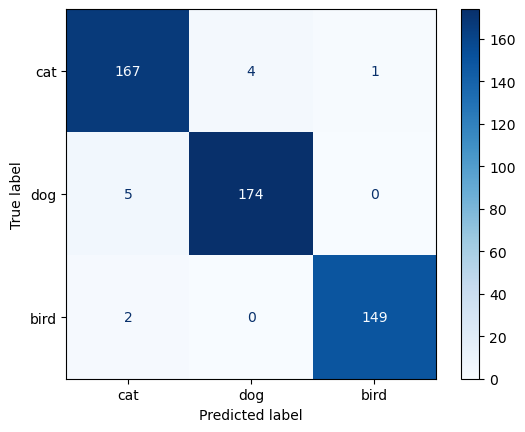

Accuracy: 0.98
Recall: 0.98
F1 Score: 0.98


In [222]:
Y_pred = model.predict(xTest)
Y_pred_classes = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(yTest, Y_pred_classes)
class_labels = ['cat', 'dog', 'bird']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = accuracy_score(yTest, Y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

recall = recall_score(yTest, Y_pred_classes, average='macro')
print(f"Recall: {recall:.2f}")

f1 = f1_score(yTest, Y_pred_classes, average='macro')  
print(f"F1 Score: {f1:.2f}")

<font color="green"><b>Question:</b></font> Find the index of wrongly classified images and display them. Do you understand why they where misclassified?

16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Index des images mal classées : [ 22  33  76 164 205 238 251 260 302 418 433 499]


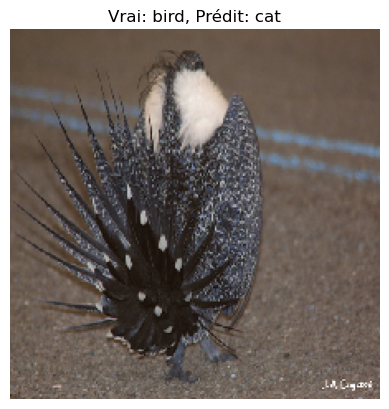

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


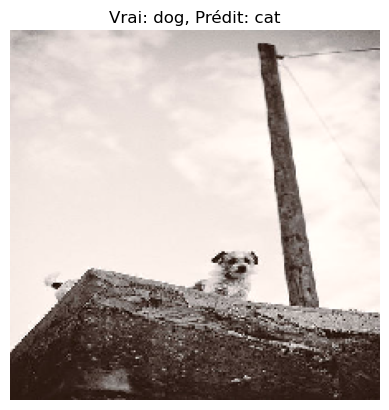

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


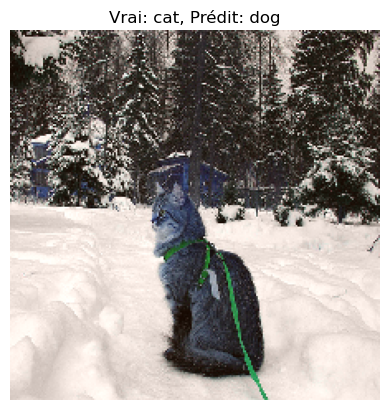

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


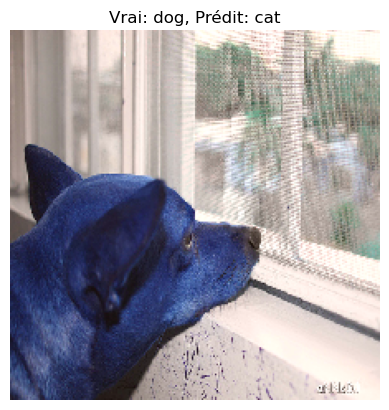

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


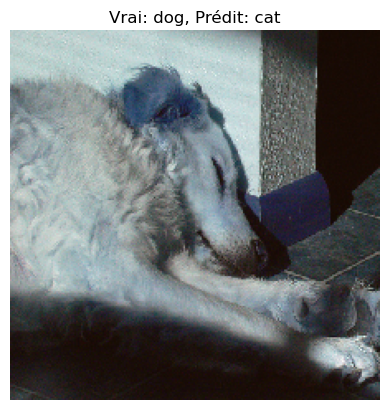

In [224]:
# Prédire les classes sur le jeu de test
Y_pred = model.predict(xTest)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Classes prédites
Y_true = np.argmax(yTestCt, axis=1)         # Classes réelles

# Trouver les index des images mal classées
wrong_classifications = np.where(Y_pred_classes != Y_true)[0]

# Afficher les index des images mal classées
print(f"Index des images mal classées : {wrong_classifications}")

# Afficher quelques images mal classées avec leurs étiquettes réelles et prédites
num_wrong = len(wrong_classifications)
num_display = min(5, num_wrong)  # Afficher au maximum 5 images mal classées

for i in range(num_display):
    idx = wrong_classifications[i]
    plt.imshow((xTest[idx]+ 125) / 255)
    plt.title(f"Vrai: {class_labels[Y_true[idx]]}, Prédit: {class_labels[Y_pred_classes[idx]]}")
    plt.axis('off')
    plt.show()

# XAI algorithms

Let's choose an image for which you will search for explanation

Probabilities :  [0.01887695 0.96931756 0.01180552]
Filename = :  C:\Users\abbon\OneDrive\Documents\SI4\deep_leaning\TP5\CatDogBird\2008_007589.jpg


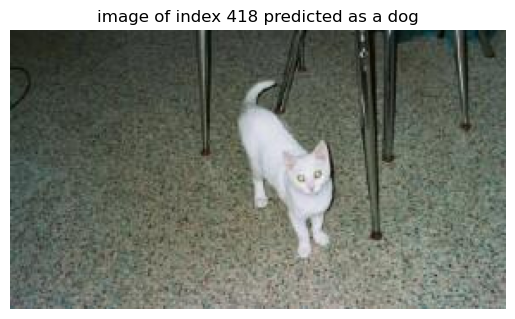

In [227]:
index = random.randint(0,len(listImgFilesTest))
img = plt.imread(listImgFilesTest[index])
img_resized = plt.imread(listImgFilesTest[index])
newImg = resize(img_resized, (224, 224), anti_aliasing=True)

predClass = np.argmax(Y_pred[index])
ypredFullProba = Y_pred[index]
print('Probabilities : ',ypredFullProba)
plt.title('image of index '+ str(index)+ ' predicted as a ' + classesNames[predClass])
plt.imshow(img)
plt.axis('off')
print('Filename = : ', listImgFilesTest[index])

wrong_classifications = np.where(predClass != Y_true)[0]

## Occlusion Map

<font color="green"><b>Question:</b></font> For this image, perform the pre-processing and predict both the best class (variable 'predClass') and the probability of this best class.

In [234]:
img_array = np.expand_dims(img, axis=0)
img_array = preprocess_input(img_array)

Y_pred = model.predict(img_array)
predClass = np.argmax(Y_pred)
best_class_prob = np.max(Y_pred)

print(f"Predicted class index: {predClass}")
print(f"Predicted class name: {class_labels[predClass]}")
print(f"Probability of best class: {best_class_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Predicted class index: 0
Predicted class name: cat
Probability of best class: 0.96


<font color="green"><b>Question:</b></font> Build a new image of the same width and height as image for which you compute this map. Set a size for the occlusion area (sizexsize). For easy centering, an odd size is more convenient. For each pixel of the map, you replace pixels of the original in a area of dimension (sizexsize), centered on this pixel by a grey color (when the image is preprocessed, grey is equal to (0,0,0)). Predict the probability of being of the 'predClass' class: this is the value of the pixel.

predicted as  cat


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


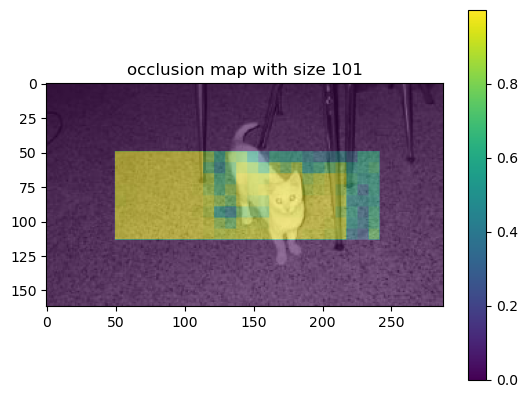

In [237]:
tmpImg = np.array(img)
tmpImg = np.expand_dims(tmpImg, axis=0)
tmpImg = preprocess_input(tmpImg)
predClass = np.argmax(model.predict(tmpImg, verbose=0))
print('predicted as ', classesNames[predClass])
#initialisations et paramètres
w,h,_ = img.shape
occmap = np.zeros((w,h))
size = 101 # size of occlusion area
hsize = size // 2 # half size
step = 8 # do not compute every position = stride
#remplissage de la carte d'occultation
for i in tqdm(range(hsize, w-hsize-1, step)):
    for j in range(hsize, h-hsize-1, step):
        tmp = np.array(tmpImg)
        tmp[0,i-hsize:i+hsize,j-hsize:j+hsize,:] = 0 # gris moyen
        p = model.predict(tmp, verbose=0)[0][predClass] # confiance dans la prédiction malgré l'occultation
        occmap[i:i+step,j:j+step] = p # duplication des valeurs pour ne pas avoir de trous
# affichage
plt.title('occlusion map with size 101')
plt.imshow(occmap)
plt.colorbar()
plt.imshow(img[:,:,1], cmap = plt.cm.gray, alpha=0.5)

<font color="green"><b>Question:</b></font> Display the occlusion map with the original image using transparency.

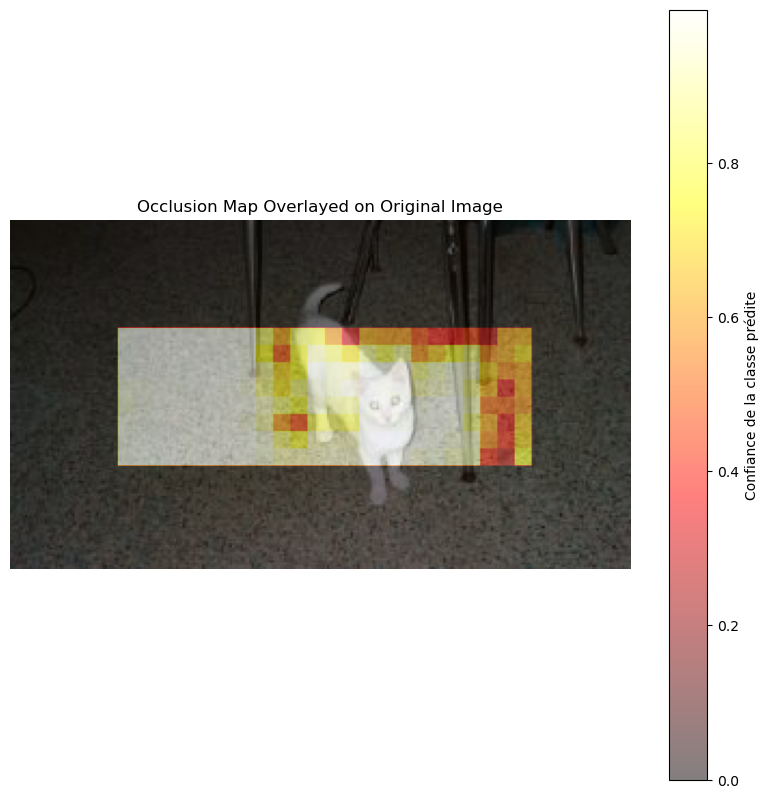

In [239]:
plt.figure(figsize=(10, 10))
plt.imshow(img)  # Affiche l'image originale
plt.imshow(occmap, cmap='hot', alpha=0.5)  # Affiche la carte d'occlusion avec transparence
plt.colorbar(label='Confiance de la classe prédite')
plt.title('Occlusion Map Overlayed on Original Image')
plt.axis('off')  # Désactiver les axes
plt.show()

## CAM

<font color="green"><b>Question:</b></font> Plot the summary in order to get the name of the last layer. Get the weights of this last layer

In [241]:
model.summary()
last_layer = model.layers[-1]

print('Last Layer Name:', last_layer.name)

weights = last_layer.get_weights()[0]
print('Weights Shape:', weights.shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,717,768 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,541 (6.02 KB)

Last Layer Name: dense
Weights Shape: (512, 3)


<font color="green"><b>Question:</b></font> Predict the features maps using the VGG model and the test data.

<font color="green"><b>Question:</b></font> Retrieve the activation map related to this picture. Retrieve the weights associated to 'predClass' class. Compute the CAM activation map. Display the CAM with the original image using transparency.

In [ ]:
# your work

<font color="green"><b>Question:</b></font> For the same image, compute the CAM related to each of the classes (cat, dog and bird). Change the original image in order to observe the different maps.

In [ ]:
# your work

## Saliency by back-propagation

Reference paper is: Simonyan, Vedaldi, and Zisserman, “Deep Inside Convolutional Networks : Visualising
Image Classification Models and Saliency Maps”, ICLR Workshop 2014.

<font color="green"><b>Question:</b></font> Compute the gradient of class score w.r.t. pixels.
Take absolute value and max over RGB channels. Pixels are now the variable and the function to derive is the function that is computing the class score from pixels. You need to set the 'requires_grad' of pixel to True, predict the probability of 'predClass' or another class and compute the gradient using the 'backward' method.

In [ ]:
# your work

<font color="green"><b>Question:</b></font> For the same image, compute the CAM related to each of the classes (cat, dog and bird). Change the original image in order to observe the different maps.

In [ ]:
# your work

## Grad CAM (without guided backprop)

<font color="green"><b>Question:</b></font> You need to compute the gradient of the class score with respect to feature maps. Plot the summary of the model in order to get the name of the last layer before the feature maps (l1) and the first layer after the feature maps (l2). Build one model m1 from the input to l1 and m2 from l2 to the output. Use m1 to compute the feature map and m2 to compute the gradients of score with respect to feature maps. The coefficients alphas are obtained by GAP of the gradients of feature maps. The GradCAM map is the ReLU of the weighted sum of features maps using alphas weights.

In [ ]:
# your work

<font color="green"><b>Question:</b></font> Compute the GradCAM for each class. Be careful that by default, in pytorch, there is accumulation of gradients (you need to zero the gradients for the next computations).

In [ ]:
# your work

## Guided gradCAM (simplified version)

<font color="green"><b>Question:</b></font> Guided GradCAM is composed of GradCAM and Guided BackPropagation. Guided BackPropagation is a variant of saliency by backpropagation: only positive gradients of positive prediction are considered. In this part, we will only consider the positive gradients. Start by displaying the positive gradients of the backpropagation.

In [ ]:
# your work

<font color="green"><b>Question:</b></font> Combine gradCAM and the previous positive gradients (point-wise multiplication).

In [1]:
# your work